In [1]:
#https://github.com/chris-stellato/capstone3/tree/main/notebooks


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import math
import random
import os
import time
from tensorflow import keras

In [3]:
convert_to_dt = ['Date']

data = pd.read_csv('C:/Users/tomwr/Datasets/Tabular/tesco-stock.csv',
                   parse_dates = convert_to_dt,
                   infer_datetime_format = True
                  )
data_normal_index = data
data_date = data.set_index('Date')
print(data.head())
print()
print(data.info())

        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-20  254.850006  255.751007  252.050003  254.449997  244.151596   
1 2021-09-21  255.550003  257.850006  254.750000  257.200012  246.790314   
2 2021-09-22  258.750000  261.649994  258.049988  261.649994  251.060181   
3 2021-09-23  263.500000  264.520996  259.500000  259.549988  249.045166   
4 2021-09-24  260.100006  260.500000  257.500000  257.500000  247.078156   

     Volume  
0  13732928  
1  18373464  
2  15194454  
3  13317828  
4   9898053  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-n

In [4]:
WINDOW_SIZE = 10 
FORECAST_LEN = 5 

In [5]:
#https://www.kaggle.com/code/rinichristy/bi-uni-lstm-rnns-for-temperature-forecasting
def windowize_data3(data, window_size, forecast_len):
    X3 = []
    y3 = []
    for i in range(len(data) - window_size - forecast_len):
        X3.append(data[i: (i + window_size)])
        #y3.append(data[:, -1][i + window_size: i + window_size + forecast_len])
        
        y3.append(data[: -1][i + window_size: i + window_size + forecast_len])

    X3 = np.array(X3) # Features
    y3 = np.array(y3) # All columns 
    ry3 = y3[:, :, 3] # selects the 3rd index (Close) - our target
    
    return np.array(X3), np.array(y3), np.array(ry3)

X3, y3, ry3 = windowize_data3(data_date, WINDOW_SIZE, FORECAST_LEN)

#print(X3.shape)
print(f'y3 shape: {y3.shape}') 
print()
print()
print(f'ry3 shape: {ry3.shape}')
print()
print()
print(f'X3 shape: {X3.shape}')

#https://stackoverflow.com/questions/52572391/extract-nth-value-from-3d-array (for below)


y3 shape: (237, 5, 6)


ry3 shape: (237, 5)


X3 shape: (237, 10, 6)


In [6]:
print(X3[0])

#10 rows as windowsize = 10. 
#6 values in each as these are the columns.

[[2.54850006e+02 2.55751007e+02 2.52050003e+02 2.54449997e+02
  2.44151596e+02 1.37329280e+07]
 [2.55550003e+02 2.57850006e+02 2.54750000e+02 2.57200012e+02
  2.46790314e+02 1.83734640e+07]
 [2.58750000e+02 2.61649994e+02 2.58049988e+02 2.61649994e+02
  2.51060181e+02 1.51944540e+07]
 [2.63500000e+02 2.64520996e+02 2.59500000e+02 2.59549988e+02
  2.49045166e+02 1.33178280e+07]
 [2.60100006e+02 2.60500000e+02 2.57500000e+02 2.57500000e+02
  2.47078156e+02 9.89805300e+06]
 [2.58899994e+02 2.59950012e+02 2.57100006e+02 2.57899994e+02
  2.47461960e+02 1.60735510e+07]
 [2.56899994e+02 2.59000000e+02 2.54399994e+02 2.56350006e+02
  2.45974701e+02 1.45675030e+07]
 [2.56950012e+02 2.58899994e+02 2.56100006e+02 2.56500000e+02
  2.46118637e+02 2.43726390e+07]
 [2.58000000e+02 2.58700012e+02 2.52800003e+02 2.53300003e+02
  2.43048141e+02 2.52676980e+07]
 [2.51199997e+02 2.51600006e+02 2.46600006e+02 2.47949997e+02
  2.37914673e+02 2.41409030e+07]]


In [30]:
print(ry3[:, 4].shape)
ry3_CLOSE = ry3[:, 4] # This is all 237 values of Close in ry3. (the windowized section of the dataset)

(237,)


**Split data into train, val, test - 80: 10: 10**

In [8]:
print(len(X3))
print(len(ry3))
print()
print(f'80% of dataset: {(len(X3) / 100) * 80}')
print(f'90% of dataset: {(len(X3) / 100) * 90}')

X_train, y_train = X3[:190], ry3[:190]
X_val, y_val = X3[190: 214], ry3[190:214]
X_test, y_test = X3[214:], ry3[214:]

print()
print(f'X_train, y_train shapes: {X_train.shape, y_train.shape}')
print(f'X_val, y_val shapes: {X_val.shape, y_val.shape}')
print(f'X_test, y_test shapes: {X_test.shape, y_test.shape}')

237
237

80% of dataset: 189.60000000000002
90% of dataset: 213.3

X_train, y_train shapes: ((190, 10, 6), (190, 5))
X_val, y_val shapes: ((24, 10, 6), (24, 5))
X_test, y_test shapes: ((23, 10, 6), (23, 5))


In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras.metrics import *
from keras.constraints import *

In [10]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#


**Scaling the data for better performance**

In [11]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range = (0, 1))


label_scaler = MinMaxScaler(feature_range = (0, 1))

################## FEATURES ###########################
#Break down arrays shapes
X_train_sequences, X_train_window, X_train_features = X_train.shape
X_val_sequences, X_val_window, X_val_features = X_val.shape
X_test_sequences, X_test_window, X_test_features = X_test.shape

#Create 2D versions - so can be transformed
X_train_2D = X_train.reshape(X_train_sequences, X_train_window * X_train_features)
X_val_2D = X_val.reshape(X_val_sequences, X_val_window * X_val_features)
X_test_2D = X_test.reshape(X_test_sequences, X_test_window * X_test_features)

#Create 2D scaled versions
X_train_2D_scaled = feature_scaler.fit_transform(X_train_2D)
X_val_2D_scaled = feature_scaler.transform(X_val_2D)
X_test_2D_scaled = feature_scaler.transform(X_test_2D)

#Create 3D scaled versions - so can be used in a model
X_train_3D_scaled = X_train_2D_scaled.reshape(X_train_sequences, X_train_window, X_train_features)
X_val_3D_scaled = X_val_2D_scaled.reshape(X_val_sequences, X_val_window, X_val_features)
X_test_3D_scaled = X_test_2D_scaled.reshape(X_test_sequences, X_test_window, X_test_features)

################## LABELS ##############################

#Create scaled 2D labels - y_train is already 2D
y_train_2D_scaled = label_scaler.fit_transform(y_train)
y_val_2D_scaled = label_scaler.transform(y_val)
y_test_2D_scaled = label_scaler.transform(y_test)

#Create scaled 1D labels
y_train_1D_scaled = y_train_2D_scaled.flatten()
y_val_1D_scaled = y_val_2D_scaled.flatten()
y_test_1D_scaled = y_test_2D_scaled.flatten()

#Create unscaled 1D labels
y_train_1D_unscaled = label_scaler.inverse_transform(y_train_2D_scaled).flatten()
y_val_1D_unscaled = label_scaler.inverse_transform(y_val_2D_scaled).flatten()
y_test_1D_unscaled = label_scaler.inverse_transform(y_test_2D_scaled).flatten()

#Create unscaled 2D labels
y_train_2D_unscaled = label_scaler.inverse_transform(y_train_2D_scaled)
y_val_2D_unscaled = label_scaler.inverse_transform(y_val_2D_scaled)
y_test_2D_unscaled = label_scaler.inverse_transform(y_test_2D_scaled)

**LSTM_2 - Using same architecture but scaled dataset**

In [12]:
lstm_2 = Sequential([
    LSTM(units = 64, input_shape = X3.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Dense(units = FORECAST_LEN, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2.compile(loss = 'mean_squared_error',
               optimizer = Adam(),
               metrics = RootMeanSquaredError()
              )

lstm_2_history = lstm_2.fit(X_train_3D_scaled, y_train_2D_scaled,
                            validation_data = (X_val_3D_scaled, y_val_2D_scaled),
                            epochs = 5
                           )

Epoch 1/5
6/6 [==============================] - 4s 178ms/step - loss: 0.2556 - root_mean_squared_error: 0.5055 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 2/5
6/6 [==============================] - 0s 13ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/5
6/6 [==============================] - 0s 13ms/step - loss: 0.0593 - root_mean_squared_error: 0.2434 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1377
Epoch 4/5
6/6 [==============================] - 0s 13ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 5/5
6/6 [==============================] - 0s 13ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447


In [37]:
lstm_2_predictions = lstm_2.predict(X_test_3D_scaled)
print()
print(lstm_2_predictions.shape) # (23, 5) is same shape as y test.

# lstm_2_predictions[lstm_2_predictions < 0] = 0 # converts any negative predictions into 0. Cannot be negative value. ----------DO I NEED THIS? 25/09/22

#23 days of +5 forecasts. Each row is next day.
#Bottom row is predictions beyond the end of dataset ( i think)

print(len(lstm_2_predictions))

print(lstm_2_predictions)

#plt.plot(lstm_2_predictions_row_mean)
#plt.plot(lstm_2_predictions_5day[:, 0: 5])
#plt.plot(lstm_2_predictions[-2]) # 2nd from bottom row - Blue
#plt.plot(lstm_2_predictions[-1]) # bottom row - Orange
#plt.plot(lstm_2_predictions)

#Each column is t+1, t+2, t+3, t+4, t+5. Further along columns are likely to be less accurate - confirmed by testing below.
#If I just wanted to look at 5 day forecasts, I would select the 5th column and plot that only. 

#https://stackoverflow.com/questions/62085898/multivariate-and-multistep-lstm     -- do I just take the top row of predictions?





#Generating some predictions from the validation dataset (ABOVE IS FROM TEST SET) - these are to use in a final graph comparing all actual values and validation and test set predictions. Wiht Axvlines.
lstm_2_predictions_VALIDATION = lstm_2.predict(X_val_3D_scaled)
lstm_2_predictions_VALIDATION_t1 = lstm_2_predictions_VALIDATION[:, 0]

lstm_2_predictions_VALIDATION_unscaled = label_scaler.inverse_transform(lstm_2_predictions_VALIDATION)
lstm_2_predictions_VALIDATION_unscaled_t1 = lstm_2_predictions_VALIDATION_unscaled[:, 0]

1/1 [==============================] - 0s 17ms/step

(23, 5)
23
[[0.26842028 0.30501235 0.27306092 0.29798728 0.29551607]
 [0.2759153  0.31280977 0.28017366 0.3057543  0.30277956]
 [0.28402746 0.32126993 0.2879231  0.3140269  0.31068522]
 [0.28308868 0.32074022 0.28767967 0.31298757 0.31013793]
 [0.28364518 0.32148492 0.28847358 0.3134256  0.31084558]
 [0.2903518  0.32775283 0.29407609 0.32006386 0.3170519 ]
 [0.30343217 0.3403934  0.30547094 0.33329028 0.32935616]
 [0.32245314 0.35854846 0.32206202 0.35260016 0.34730068]
 [0.34271175 0.37862736 0.340776   0.37306786 0.36673445]
 [0.35505274 0.39174718 0.3535833  0.38549387 0.37920767]
 [0.35411027 0.39206237 0.3549223  0.38450718 0.37940794]
 [0.34242132 0.3814522  0.34616077 0.3724878  0.36905187]
 [0.31495628 0.35581517 0.32354385 0.3448227  0.34382617]
 [0.27737918 0.3207306  0.29205507 0.30705604 0.30903974]
 [0.23378989 0.2789514  0.2539118  0.2633298  0.26788774]
 [0.1959869  0.24117704 0.21868327 0.22554803 0.23110288]
 [0.1523

In [14]:
#Each variable is a column. Each column is the t+1 forecast.

lstm_2_predictions_t1 = lstm_2_predictions[:, 0]
lstm_2_predictions_t2 = lstm_2_predictions[:, 1]
lstm_2_predictions_t3 = lstm_2_predictions[:, 2]
lstm_2_predictions_t4 = lstm_2_predictions[:, 3]
lstm_2_predictions_t5 = lstm_2_predictions[:, 4]

#Get metrics for each forecast length

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #y_true, y_pred

lstm_2_predictions_t1_mae = mean_absolute_error(y_test_2D_scaled[:, 0], lstm_2_predictions_t1)
lstm_2_predictions_t2_mae = mean_absolute_error(y_test_2D_scaled[:, 1], lstm_2_predictions_t2)
lstm_2_predictions_t3_mae = mean_absolute_error(y_test_2D_scaled[:, 2], lstm_2_predictions_t3)
lstm_2_predictions_t4_mae = mean_absolute_error(y_test_2D_scaled[:, 3], lstm_2_predictions_t4)
lstm_2_predictions_t5_mae = mean_absolute_error(y_test_2D_scaled[:, 4], lstm_2_predictions_t5)

print(f't+1 forecast mae: {lstm_2_predictions_t1_mae}')
print(f't+2 forecast mae: {lstm_2_predictions_t2_mae}')
print(f't+3 forecast mae: {lstm_2_predictions_t3_mae}')
print(f't+4 forecast mae: {lstm_2_predictions_t4_mae}')
print(f't+5 forecast mae: {lstm_2_predictions_t5_mae}')

t+1 forecast mae: 0.1145002122434774
t+2 forecast mae: 0.13067702545356716
t+3 forecast mae: 0.14581579651491589
t+4 forecast mae: 0.17392769883791812
t+5 forecast mae: 0.19904763073950904


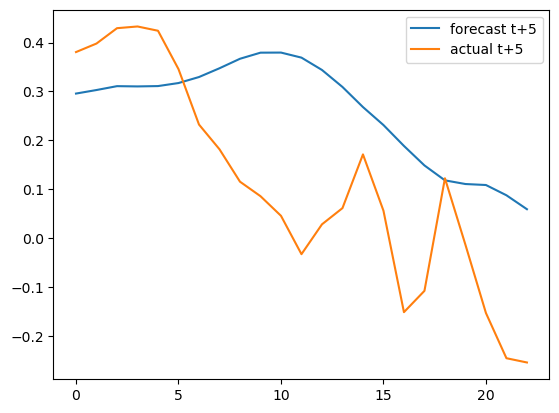

In [15]:
#Plotting scaled lstm_2_prediction forecast types against actual conditions - ALL SCALED STILL

#plt.plot(lstm_2_predictions_t1, label = 'forecast t+1')
plt.plot(lstm_2_predictions_t5, label = 'forecast t+5')
#plt.plot(y_test_2D_scaled[:, 0], label = 'actual t+1')
plt.plot(y_test_2D_scaled[:, 4], label = 'actual t+5')

plt.legend()
plt.show()

[[261.4805  263.5772  261.7464  263.17465 263.03308]
 [261.90994 264.024   262.15396 263.61972 263.44928]
 [262.3748  264.5088  262.598   264.09375 263.90225]
 [262.32098 264.47842 262.58405 264.03418 263.8709 ]
 [262.35287 264.5211  262.62955 264.0593  263.91144]
 [262.73718 264.88022 262.95056 264.43964 264.2671 ]
 [263.48666 265.60455 263.6035  265.19754 264.9721 ]
 [264.57657 266.6448  264.55417 266.304   266.00034]
 [265.73737 267.79535 265.62646 267.4768  267.1139 ]
 [266.44452 268.54712 266.36032 268.1888  267.8286 ]
 [266.39053 268.56516 266.43704 268.13226 267.8401 ]
 [265.72073 267.9572  265.93503 267.44354 267.24667]
 [264.147   266.4882  264.63904 265.85834 265.80124]
 [261.99384 264.47787 262.83478 263.6943  263.80798]
 [259.49615 262.08392 260.64914 261.18878 261.44995]
 [257.33005 259.91946 258.63055 259.0239  259.3422 ]
 [254.8285  257.3743  256.26053 256.51813 256.89212]
 [252.52504 254.96175 253.9976  254.21426 254.60512]
 [250.8062  253.07214 252.19891 252.50482 252.

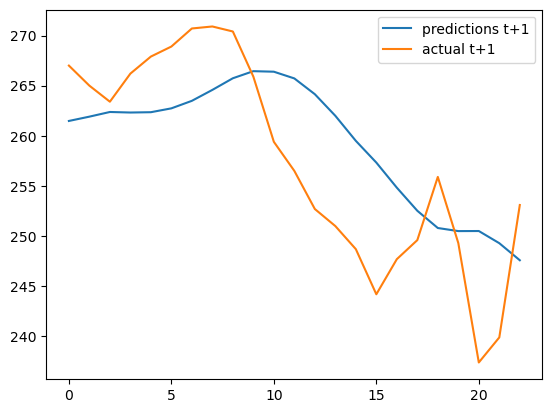

In [16]:
#Generating unscaled predictions. These are the ones to actually plot

lstm_2_predictions_unscaled = label_scaler.inverse_transform(lstm_2_predictions)
print(lstm_2_predictions_unscaled)

lstm_2_predictions_unscaled_t1 = lstm_2_predictions_unscaled[:, 0]
lstm_2_predictions_unscaled_t2 = lstm_2_predictions_unscaled[:, 1]
lstm_2_predictions_unscaled_t3 = lstm_2_predictions_unscaled[:, 2]
lstm_2_predictions_unscaled_t4 = lstm_2_predictions_unscaled[:, 3]
lstm_2_predictions_unscaled_t5 = lstm_2_predictions_unscaled[:, 4]

plt.plot(lstm_2_predictions_unscaled_t1, label = 'predictions t+1')
plt.plot(y_test_2D_unscaled[:, 0], label = 'actual t+1')
plt.legend()
plt.show()

**Plotting all previous data. Then test data forecasts - different coloured for different t + 5 forecasts.**

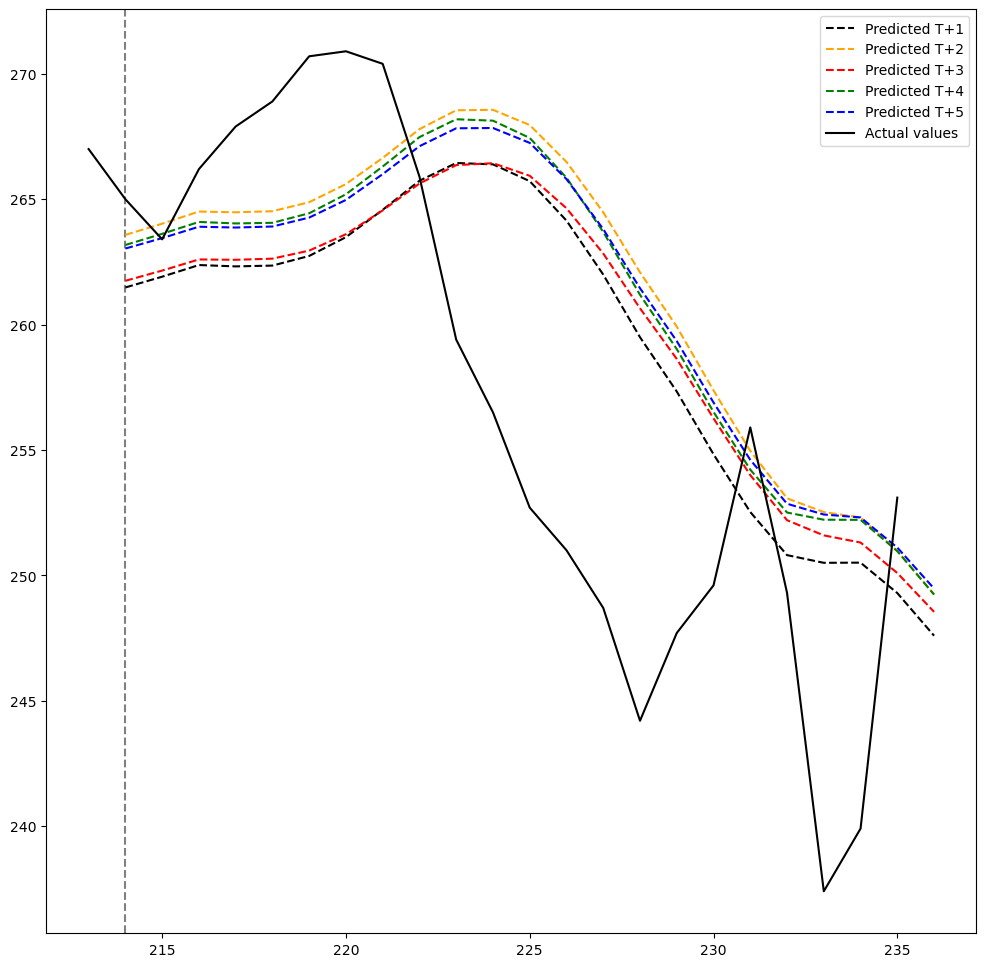

In [17]:
def plot_all_unscaled_and_test_forecasts(y, t1_forecast, t2_forecast, t3_forecast, t4_forecast, t5_forecast):
    
    plt.figure(figsize = (12, 12))
    #plt.plot(y[:, 0], label = 'Actual T+1', linestyle = 'solid', color = 'black')
    #plt.plot(y[:, 1], label = 'Actual T+2', linestyle = 'solid', color = 'orange')
    #plt.plot(y[:, 2], label = 'Actual T+3', linestyle = 'solid', color = 'red')
    #plt.plot(y[:, 3], label = 'Actual T+4', linestyle = 'solid', color = 'green')
    #plt.plot(y[:, 4], label = 'Actual T+5', linestyle = 'solid', color = 'blue')
    
    plt.axvline(x = 214, linestyle = 'dashed', color = 'grey')
    
    plt.plot(range(214, 237), t1_forecast, linestyle = 'dashed', color = 'black', label = 'Predicted T+1')
    plt.plot(range(214, 237), t2_forecast, linestyle = 'dashed', color = 'orange', label = 'Predicted T+2')
    plt.plot(range(214, 237), t3_forecast, linestyle = 'dashed', color = 'red', label = 'Predicted T+3')
    plt.plot(range(214, 237), t4_forecast, linestyle = 'dashed', color = 'green', label = 'Predicted T+4')
    plt.plot(range(214, 237), t5_forecast, linestyle = 'dashed', color = 'blue', label = 'Predicted T+5')
    
    #This creates 6 small plots. Problem is its too small to see clear differences.
    #fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True)
    #ax[0, 0].plot(y[:, 0], label = 'Actual T+1')
    #ax[0, 0].plot(range(214, 237), t1_forecast, label = 'Predicted T+1')
    #ax[0, 0].set_title('T+1')
    
    #ax[0, 1].plot(y[:, 1], label = 'Actual T+2')
    #ax[0, 1].plot(range(214, 237), t2_forecast, label = 'Predicted T+2')
    #ax[0, 1].set_title('T+2')
    
    plt.plot(range(213, 236), y_test[-23:, 0], label = 'Actual values', linestyle = 'solid', color = 'black') # Last 23 vlaues of y_test first column (T+1). Shifted 1 position to the left so it's T+1 - 1 = T. Actual values.
    
    plt.legend()
    plt.show()
    
    
plot_all_unscaled_and_test_forecasts(ry3, lstm_2_predictions_unscaled_t1, lstm_2_predictions_unscaled_t2, lstm_2_predictions_unscaled_t3, lstm_2_predictions_unscaled_t4, lstm_2_predictions_unscaled_t5)

In [18]:
print(y_test[-23:].shape)

(23, 5)


In [40]:
def plot_forecast_vs_actual(test_forecast, full_actuals, validation_forecast):
    
    plt.figure(figsize = (12,12))
    plt.suptitle('forecast values compared to actual values of Close')
    
    plt.plot(full_actuals, linestyle = 'solid', color = 'black', label = 'Observed values')
    plt.plot(range(214, 237), test_forecast, linestyle = 'dashed', color = 'red', label = 'test forecast values')
    plt.plot(range(190, 214), validation_forecast, linestyle = 'dashed', color = 'blue', label = 'validation forecast values')
    
    #Vertical lines marking validation and test boundaries.
    plt.axvline(x = 190, linestyle = 'dashed', color = 'yellow', label = 'validation')
    plt.axvline(x = 214, linestyle = 'dashed', color = 'yellow', label = 'test')
    
    plt.legend()
    plt.show()
    

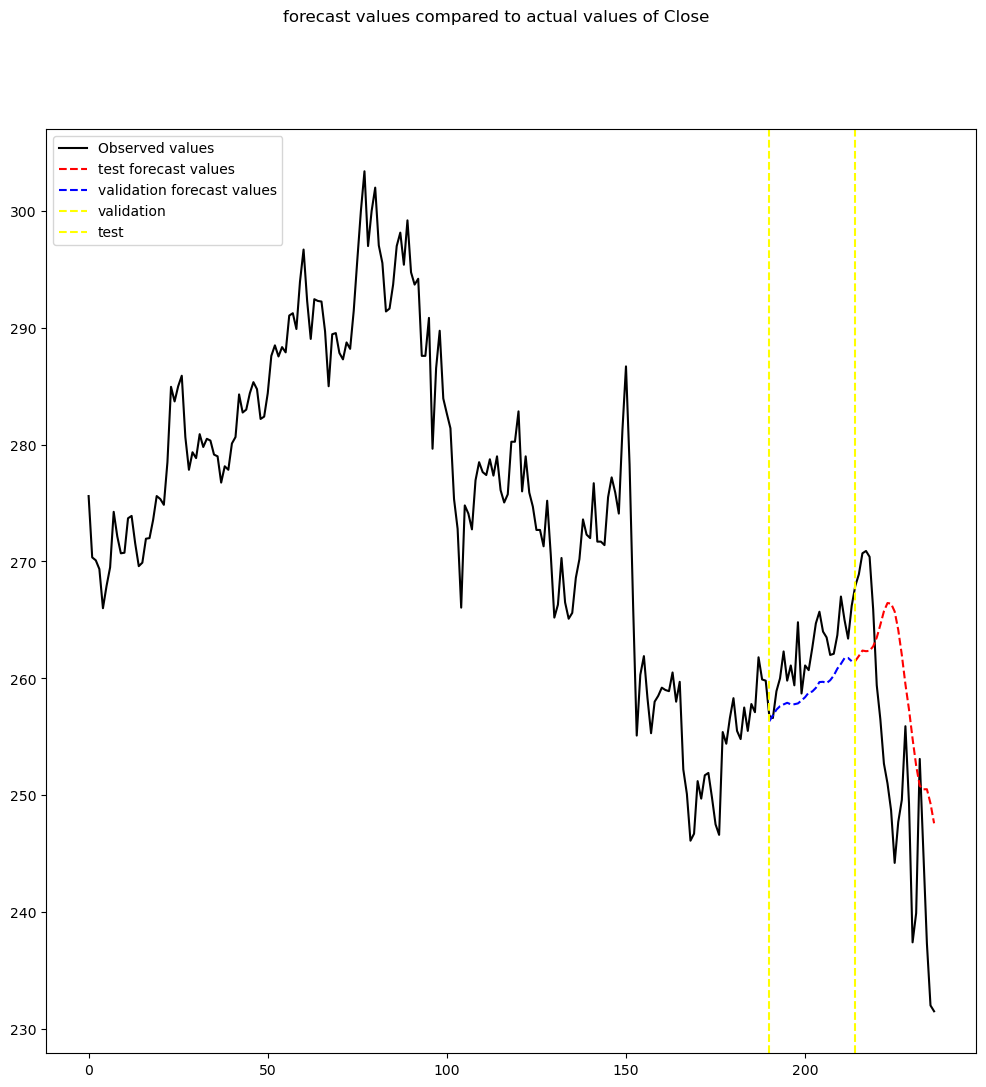

In [41]:
plot_forecast_vs_actual(lstm_2_predictions_unscaled_t1, ry3_CLOSE, lstm_2_predictions_VALIDATION_unscaled_t1)